# Ad detection notebook

## Importing all the neccessary libraries

In [ ]:
import pandas as pd
import re
import traceback
import numpy as np
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import tensorflow as tf
from sklearn.tree import DecisionTreeClassifier
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import metrics  
from sklearn.pipeline import Pipeline
from numpy import mean
from numpy import absolute
from numpy import sqrt
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
import pickle
from sklearn.metrics import classification_report
from google.colab import drive
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn import tree
from xgboost import XGBClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import StackingClassifier
import lightgbm as lgb
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
import string

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def tokenize(f):
    tokens = f
    total = []
    # make tokens based on dots (.) and dashes (-)
    for i in tokens:
        dash = str(i).split('-')	
        dots = []
        for j in range(0,len(dash)):
            temp = str(dash[j]).split('.')
            dots = dots + temp
        total = total + dash + dots
    # remove duplicate
    total = list(set(total))	
    # remove com since it is very common
    if 'com' in total:
        total.remove('com')	
    return total

In [ ]:
# Check if the GPU is detected
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13497221381952589616
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14385217536
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7658901408655230835
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


### Loading data
- Initially, I had multiple datasets containing lists of only ad servers and non-ad servers. I combined them all to create a dataset 'all.csv'.
- Since all.csv had multiple overlapping entries, I deleted the duplicates and saved it as another file 'all-without-duplicates'
```
df = pd.read_csv("/content/drive/My Drive//lists/all.csv",converters={'domain': convert_dtype,'class': convert_dtype}) 
df = df.drop_duplicates()
df.to_csv('/content/drive/My Drive//lists/all-without-duplicates.csv')

```


In [ ]:
df = pd.read_csv("/content/drive/My Drive//lists/all-without-duplicates.csv") # Dataset is now stored in a Pandas Dataframe
df.drop_duplicates(inplace = True)
df['label'] = df['label'].map({'1': '0', '0': '1'}) # issue with the original dataset where non ads were marked as 1 and ads as 0. This reverses it.
df

,url,label
0,google.com,0
1,youtube.com,0
2,facebook.com,0
3,amazonaws.com,0
4,netflix.com,0
...,...,...
1474707,slview.psne.jp,1
1474708,x.vipergirls.to,1
1474709,x0r.urlgalleries.net,1
1474710,yotta.scrolller.com,1


## Preprocessing and feature extraction
This block of code is used for preprocessing the dataset, removing unwanted patterns, and extracting meaningful features from the dataset. Here, the features extracted are has_ad(does it contain the word 'ad'),num_dots(number of dots in the url, excluding subdomain if any),num_hyphens(number of hyphens), num_digits(number of digits in the URL)


In [ ]:
ad_pattern = r'\b(ad|ads|analytics\.)\b'
subdomain_pattern = r'^www\.'
dot_pattern = r'.'
hyphen_pattern = r'-'
digit_pattern = r'\d'

batch_size = 10000
input_file = '/content/drive/My Drive//lists/all-without-duplicates.csv'
output_file = '/content/drive/My Drive//lists/preprocessed.csv'

with open(input_file, 'r') as f_in, open(output_file, 'w') as f_out:
    for chunk in pd.read_csv(f_in, chunksize=batch_size):
        for index, row in chunk.iterrows():
            url = row['url']
            is_ad = row['class']
            has_ad = int(bool(re.search(ad_pattern, url)))
            re.sub(subdomain_pattern,'', url)
            num_dots = url.count(dot_pattern)
            num_hyphens = url.count(hyphen_pattern)
            num_digits = len(re.findall(digit_pattern, url))

            f_out.write(f'{url},{has_ad},{num_dots},{num_hyphens},{num_digits},{is_ad}\n')


###  Load the preprocessed features and the class label into a Pandas DataFrame

In [ ]:
input_file = '/content/drive/My Drive//lists/preprocessed.csv'
data = pd.read_csv(input_file, header=None, names=['url', 'has_ad', 'num_dots', 'num_hyphens', 'num_digits', 'is_ad'])
data.info

<bound method DataFrame.info of                           url  has_ad  num_dots  num_hyphens  num_digits  \
0                  google.com       0         1            0           0   
1                 youtube.com       0         1            0           0   
2                facebook.com       0         1            0           0   
3               amazonaws.com       0         1            0           0   
4                 netflix.com       0         1            0           0   
...                       ...     ...       ...          ...         ...   
1474708        slview.psne.jp       0         2            0           0   
1474709       x.vipergirls.to       0         2            0           0   
1474710  x0r.urlgalleries.net       0         2            0           1   
1474711   yotta.scrolller.com       0         2            0           0   
1474712      ytre9jk.txxx.com       0         2            0           1   

         is_ad  
0          0.0  
1          0.0  
2   

In [ ]:
input_file = '/content/drive/My Drive//lists/preprocessed.csv'

data = pd.read_csv(input_file, header=None, names=['url', 'has_ad', 'num_dots', 'num_hyphens', 'num_digits', 'is_ad'])
data = data.dropna()

## Neural Networks
The preprocessed dataset is loaded into a dataframe, and split into 3 sets:
- Training data: Train the model
- Validation data: Evaluate the model after running each epoch
- Test data: Test the final model

The model is created with one input layer, 6 hidden dense layers, and one output layer. The model is then trained on the training data and evaluated using the validation and test data.

In [ ]:
np.random.seed(42)
batch_size = 32
epochs = 100
input_file = '/content/drive/My Drive/lists/preprocessed.csv'

data = pd.read_csv(input_file, header=None, names=['url', 'has_ad', 'num_dots', 'num_hyphens', 'num_digits', 'is_ad'])
data = data.dropna()
data = data.groupby('is_ad').apply(lambda x: x.sample(n=28040))
# shuffle the DataFrame rows to avoid the model only predicting one value
data = data.sample(frac = 1)
data.drop(['url'],axis = 1, inplace=True)
_data, test_data = train_test_split(data, test_size=0.2, stratify=data['is_ad'])
train_data, val_data = train_test_split(_data, test_size=0.2, stratify=_data['is_ad'])

input_shape = (train_data.shape[1] - 2,)

input_dim = 3
model = Sequential()    
model.add(Dense(256, input_dim = input_dim , activation = 'relu'))    
model.add(Dense(128, activation = 'relu'))    
model.add(Dense(64, activation = 'relu'))    
model.add(Dense(32, activation = 'relu'))    
model.add(Dense(16, activation = 'relu'))    
model.add(Dense(5, activation = 'softmax'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss = 'categorical_crossentropy' ,optimizer='adam' , metrics = 'accuracy' )
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model.fit(train_data.iloc[:, 1:-1], train_data.iloc[:, -1], epochs=epochs, validation_data=(val_data.iloc[:, 1:-1], val_data.iloc[:, -1]), callbacks=[early_stop])

loss, acc = model.evaluate(test_data.iloc[:, 1:-1], test_data.iloc[:, -1], batch_size=batch_size)
print('Test accuracy:', acc)

model.save('/content/drive/My Drive/neural-net.h5')

Epoch 1/100


/usr/local/lib/python3.9/dist-packages/tensorflow/python/util/dispatch.py:1176: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


1117/1122 [============================>.] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.4991

/usr/local/lib/python3.9/dist-packages/tensorflow/python/util/dispatch.py:1176: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


1122/1122 [==============================] - 14s 7ms/step - loss: 0.0000e+00 - accuracy: 0.4991 - val_loss: 0.0000e+00 - val_accuracy: 0.4999
Epoch 2/100
1122/1122 [==============================] - 5s 5ms/step - loss: 0.0000e+00 - accuracy: 0.5000 - val_loss: 0.0000e+00 - val_accuracy: 0.4999
Epoch 3/100
1122/1122 [==============================] - 6s 6ms/step - loss: 0.0000e+00 - accuracy: 0.5000 - val_loss: 0.0000e+00 - val_accuracy: 0.4999
Epoch 4/100
1122/1122 [==============================] - 6s 5ms/step - loss: 0.0000e+00 - accuracy: 0.5000 - val_loss: 0.0000e+00 - val_accuracy: 0.4999
Epoch 5/100
1122/1122 [==============================] - 5s 5ms/step - loss: 0.0000e+00 - accuracy: 0.5000 - val_loss: 0.0000e+00 - val_accuracy: 0.4999
Epoch 6/100
1122/1122 [==============================] - 6s 6ms/step - loss: 0.0000e+00 - accuracy: 0.5000 - val_loss: 0.0000e+00 - val_accuracy: 0.4999
Epoch 7/100
1122/1122 [==============================] - 5s 5ms/step - loss: 0.0000e+00 - acc

### Classification report of the model

In [ ]:
le = LabelEncoder()
X_test = test_data.iloc[:, 1:-1]
y_test = test_data.iloc[:, -1]
y_pred = model.predict(X_test)
y_test_label = le.fit_transform(y_test)
y_pred_label = le.fit_transform(y_pred)
print(classification_report(y_test_label, y_pred_label))

351/351 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0       0.51      0.27      0.36      5608
           1       0.50      0.73      0.60      5608

    accuracy                           0.50     11216
   macro avg       0.50      0.50      0.48     11216
weighted avg       0.50      0.50      0.48     11216



/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Confusion matrix of the model

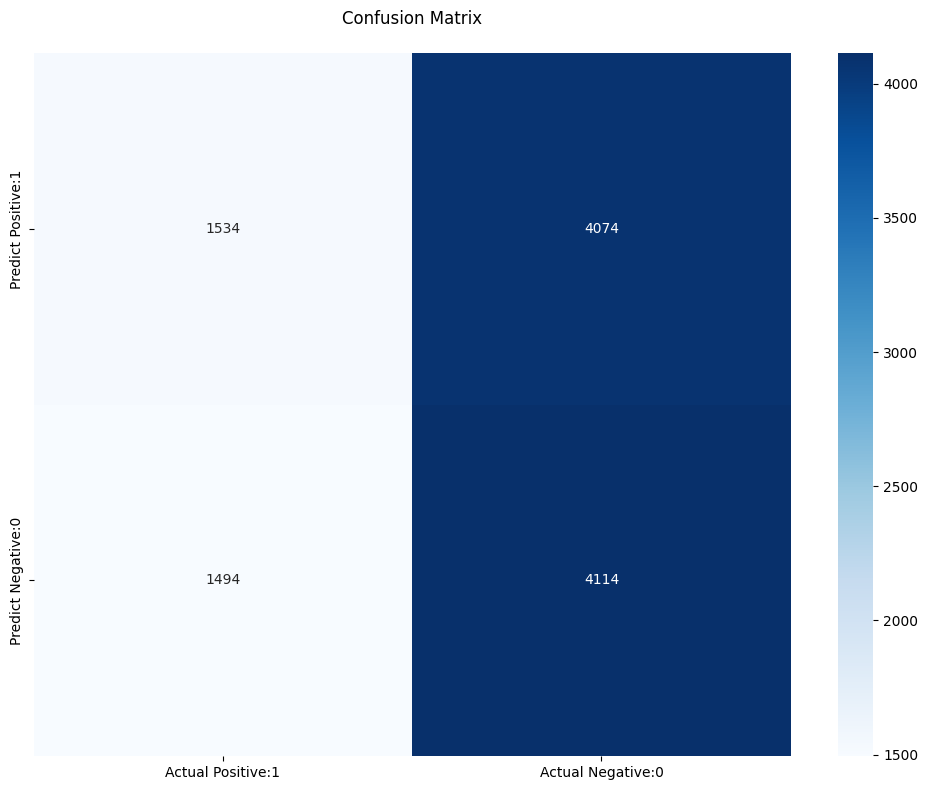

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
cm = confusion_matrix(y_test_label, y_pred_label)
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], index=['Predict Positive:1', 'Predict Negative:0'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix\n")
plt.tight_layout()

### A summary of the trained model

In [ ]:
model = load_model('/content/drive/My Drive/my_model.h5')
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 64)                320       
                                                                 
 dense_22 (Dense)            (None, 32)                2080      
                                                                 
 dense_23 (Dense)            (None, 1)                 33        
                                                                 
Total params: 2,433
Trainable params: 2,433
Non-trainable params: 0
_________________________________________________________________


## Logistic Regression
The dataset is loaded into a dataframe, tokenized and vectorized, and then split into train and test sets. \\
The logistic regression model is then run on the training set, and tested using the testing set.

In [ ]:
file = '/content/drive/My Drive/all-without-duplicates.csv'
urls_data = pd.read_csv(file)
urls_data = urls_data.groupby('label').apply(lambda x: x.sample(n=28040))
url_list = urls_data["url"]
y = urls_data["label"]
vectorizer = TfidfVectorizer(tokenizer=tokenize)
X = vectorizer.fit_transform(url_list)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)   

logit = LogisticRegression()	
logit.fit(X_train, y_train)

/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


LogisticRegression()

In [ ]:
print("Accuracy ",logit.score(X_test, y_test))
print("Accuracy ",logit.score(X_train, y_train))

Accuracy  0.6932061340941512
Accuracy  0.9516984664764622


A classification report and a confusion matrix is generated for the testing results.

### Classification report of the model

In [ ]:
y_pred = logit.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.53      0.63      5602
           1       0.65      0.85      0.74      5614

    accuracy                           0.69     11216
   macro avg       0.72      0.69      0.69     11216
weighted avg       0.72      0.69      0.69     11216



### Confusion matrix of the model

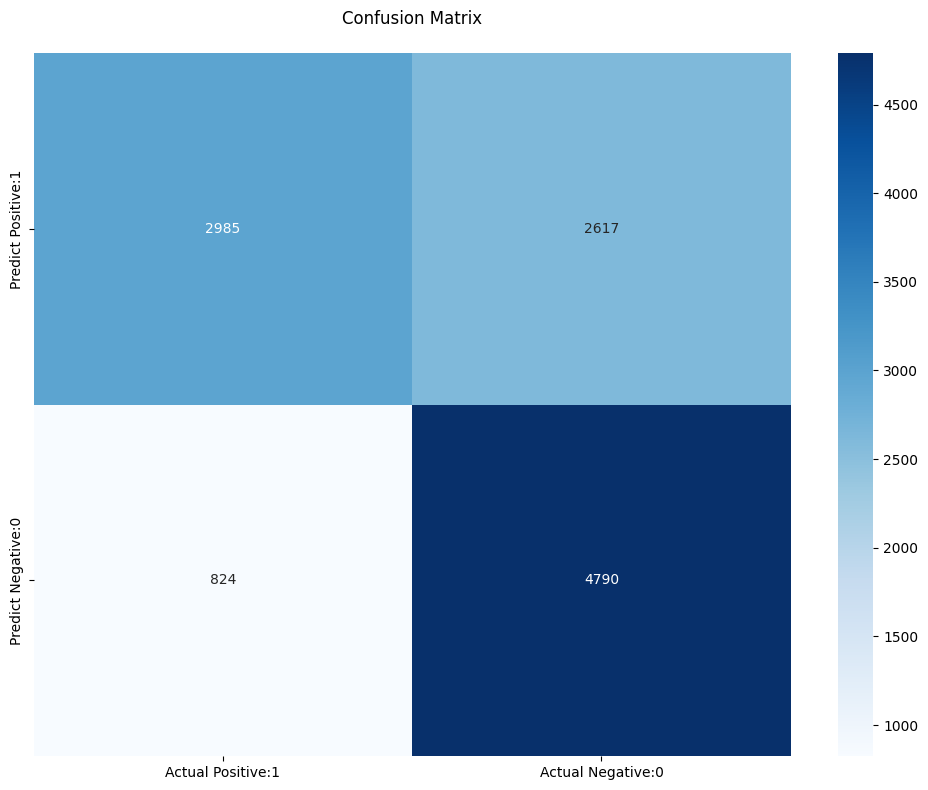

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
cm = confusion_matrix(y_test, y_pred)
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], index=['Predict Positive:1', 'Predict Negative:0'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix\n")
plt.tight_layout()

### Randomized Search Cross Validation

In [ ]:
params_logit = {'penalty': ['l1', 'l2'],
'C': [1 , 0.5, 0.1, 0.05, 0.01],
'class_weight': ['balanced', None],
'solver': ['liblinear', 'lbfgs'],
'max_iter': [100,200,300]}

file = '/content/drive/My Drive/all-without-duplicates.csv'
urls_data = pd.read_csv(file)
urls_data = urls_data.groupby('label').apply(lambda x: x.sample(n=28040))
le = LabelEncoder()
label = le.fit_transform(urls_data['label'])
urls_data.drop('label', axis=1, inplace=True)
urls_data['label'] = label
url_list = urls_data['url']
vectorizer = TfidfVectorizer(tokenizer=tokenize)
X_tfid = vectorizer.fit_transform(url_list)
y_tfid = urls_data["label"]
X_train, X_test, y_train, y_test = train_test_split(X_tfid, y_tfid, test_size=0.2, random_state=42)   
logit = LogisticRegression()	
rand_search_logit = RandomizedSearchCV(logit, param_distributions=params_logit, n_iter=20, cv=5,n_jobs=-1)
rand_search_logit.fit(X_train,y_train)
print("Accuracy ",rand_search_logit.score(X_test, y_test))
print("Accuracy ",rand_search_logit.score(X_train, y_train))

/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
20 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(se

Accuracy  0.6982881597717546
Accuracy  0.9560003566333809


#### Classification report of the model

In [ ]:
y_pred = rand_search_logit.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.51      0.63      5602
           1       0.65      0.89      0.75      5614

    accuracy                           0.70     11216
   macro avg       0.74      0.70      0.69     11216
weighted avg       0.74      0.70      0.69     11216



#### Confusion matrix of the model

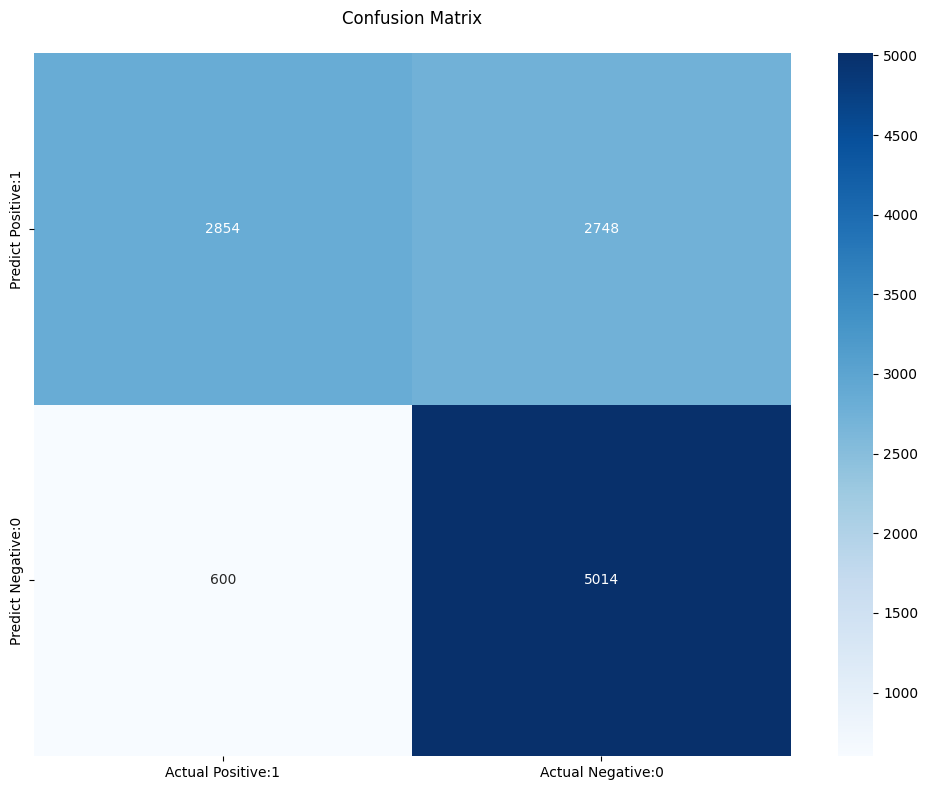

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
cm = confusion_matrix(y_test, y_pred)
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], index=['Predict Positive:1', 'Predict Negative:0'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix\n")
plt.tight_layout()

## Decision Trees
The dataset is loaded into a dataframe, tokenized and vectorized, and then split into train and test sets. \\
The decision tree model is then run on the training set, and tested using the testing set.

In [ ]:
file = '/content/drive/My Drive/all-without-duplicates.csv'
urls_data = pd.read_csv(file)
urls_data = urls_data.groupby('label').apply(lambda x: x.sample(n=28040))
url_list = urls_data["url"]
y = urls_data["label"]
vectorizer = TfidfVectorizer(tokenizer=tokenize)
X = vectorizer.fit_transform(url_list)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)   

dtree = DecisionTreeClassifier()
dtree.fit(X_train, y_train)
print("Accuracy ",dtree.score(X_test, y_test))
print("Accuracy ",dtree.score(X_train, y_train))

/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Accuracy  0.6997146932952925
Accuracy  0.9984174393723253


### Tree view of the trained model

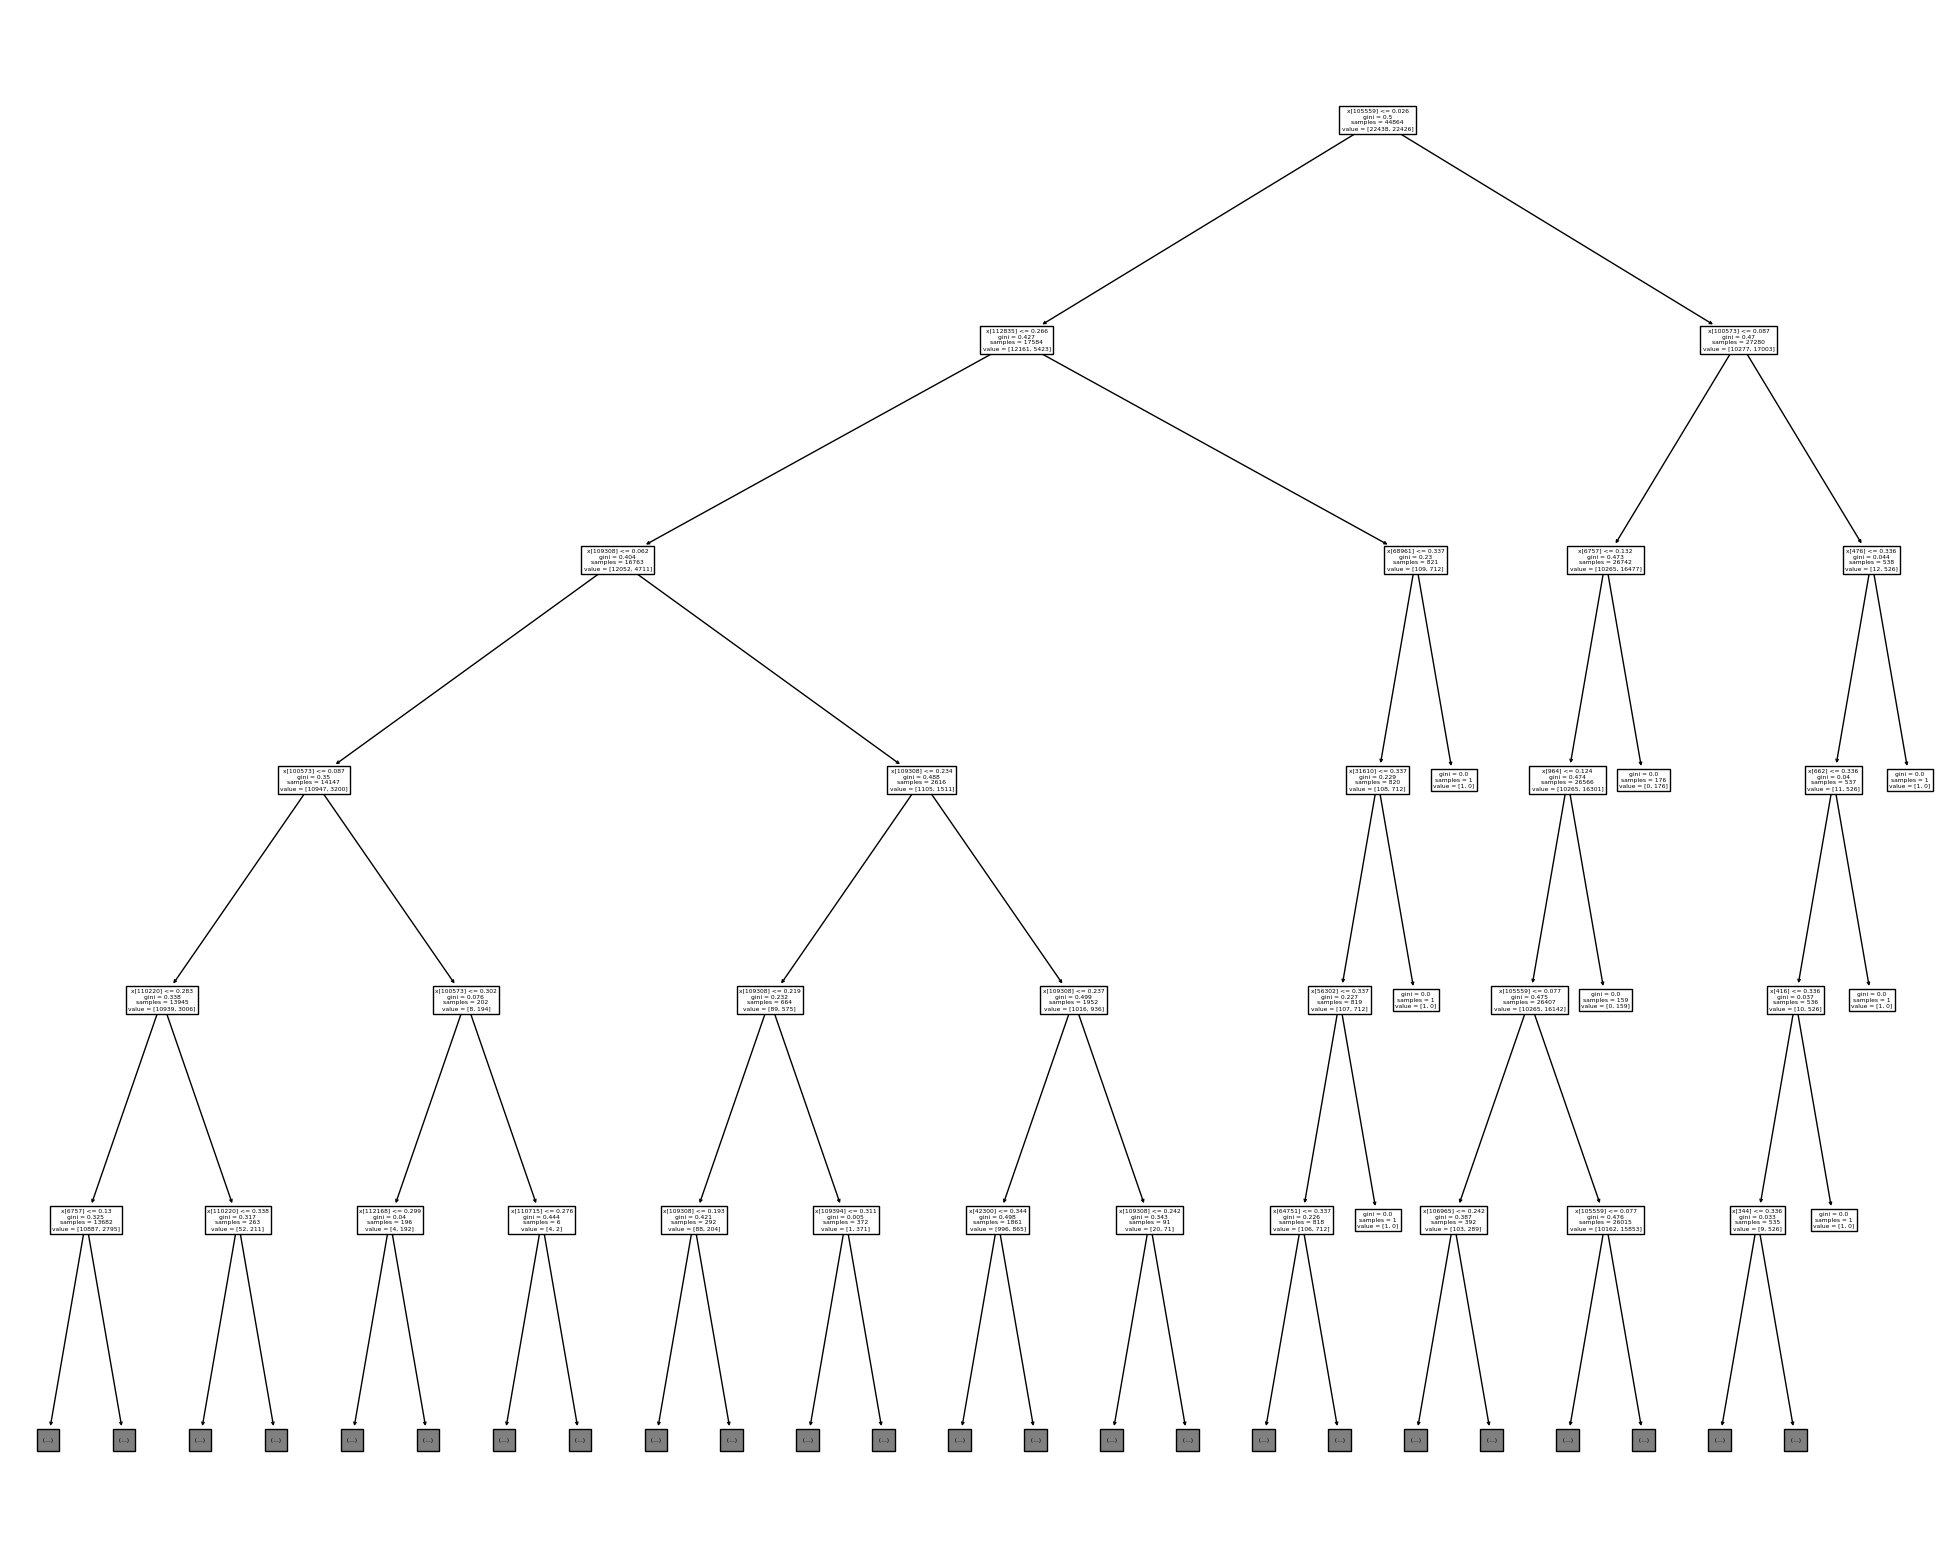

In [ ]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(dtree, max_depth = 5)

### Classification report of the model

In [ ]:
y_pred = dtree.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.54      0.64      5602
           1       0.65      0.85      0.74      5614

    accuracy                           0.69     11216
   macro avg       0.71      0.69      0.69     11216
weighted avg       0.71      0.69      0.69     11216



### Confusion matrix of the model

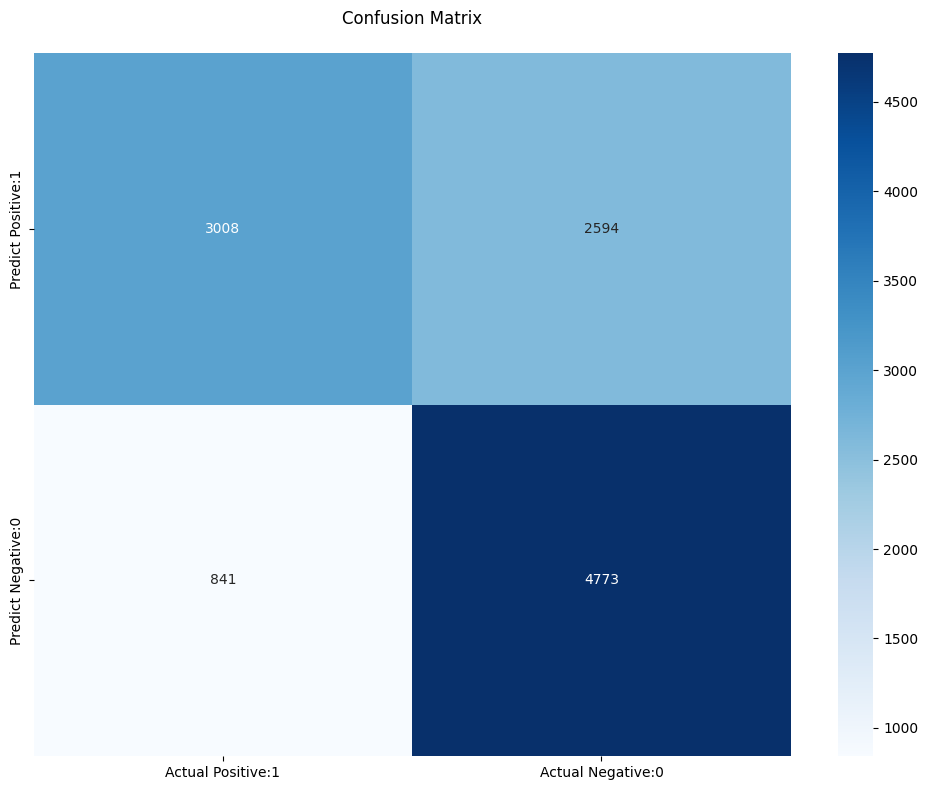

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
cm = confusion_matrix(y_test, y_pred)
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], index=['Predict Positive:1', 'Predict Negative:0'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix\n")
plt.tight_layout()

### Randomized Search Cross Validation

In [ ]:
file = '/content/drive/My Drive/all-without-duplicates.csv'
urls_data = pd.read_csv(file)
urls_data = urls_data.groupby('label').apply(lambda x: x.sample(n=28040))
url_list = urls_data["url"]
y = urls_data["label"]
vectorizer = TfidfVectorizer(tokenizer=tokenize)
X = vectorizer.fit_transform(url_list)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)   


dtree2 = DecisionTreeClassifier()

param1 =      {
              'criterion': ['gini', 'entropy'],
              'splitter': ['best', 'random'],
              'max_depth': [None, 5, 10, 15, 20],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4],
              'max_features': ['auto', 'sqrt', 'log2', None]}

rand_search_dtree = RandomizedSearchCV(dtree2, param_distributions=param1, n_iter=10, cv=5,n_jobs=-1)

rand_search_dtree.fit(X_train, y_train)
print("Accuracy ",rand_search_dtree.score(X_test, y_test))
print("Accuracy ",rand_search_dtree.score(X_train, y_train))

/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Accuracy  0.6972182596291013
Accuracy  0.6984887660485022


In [ ]:
best_params = rand_search_dtree.best_params_
dtree2.set_params(**best_params)
dtree2.fit(X_train, y_train)
print("Accuracy ",dtree2.score(X_test, y_test))
print("Accuracy ",dtree2.score(X_train, y_train))

Accuracy  0.6951676176890157
Accuracy  0.698644793152639


#### Tree view of the trained model

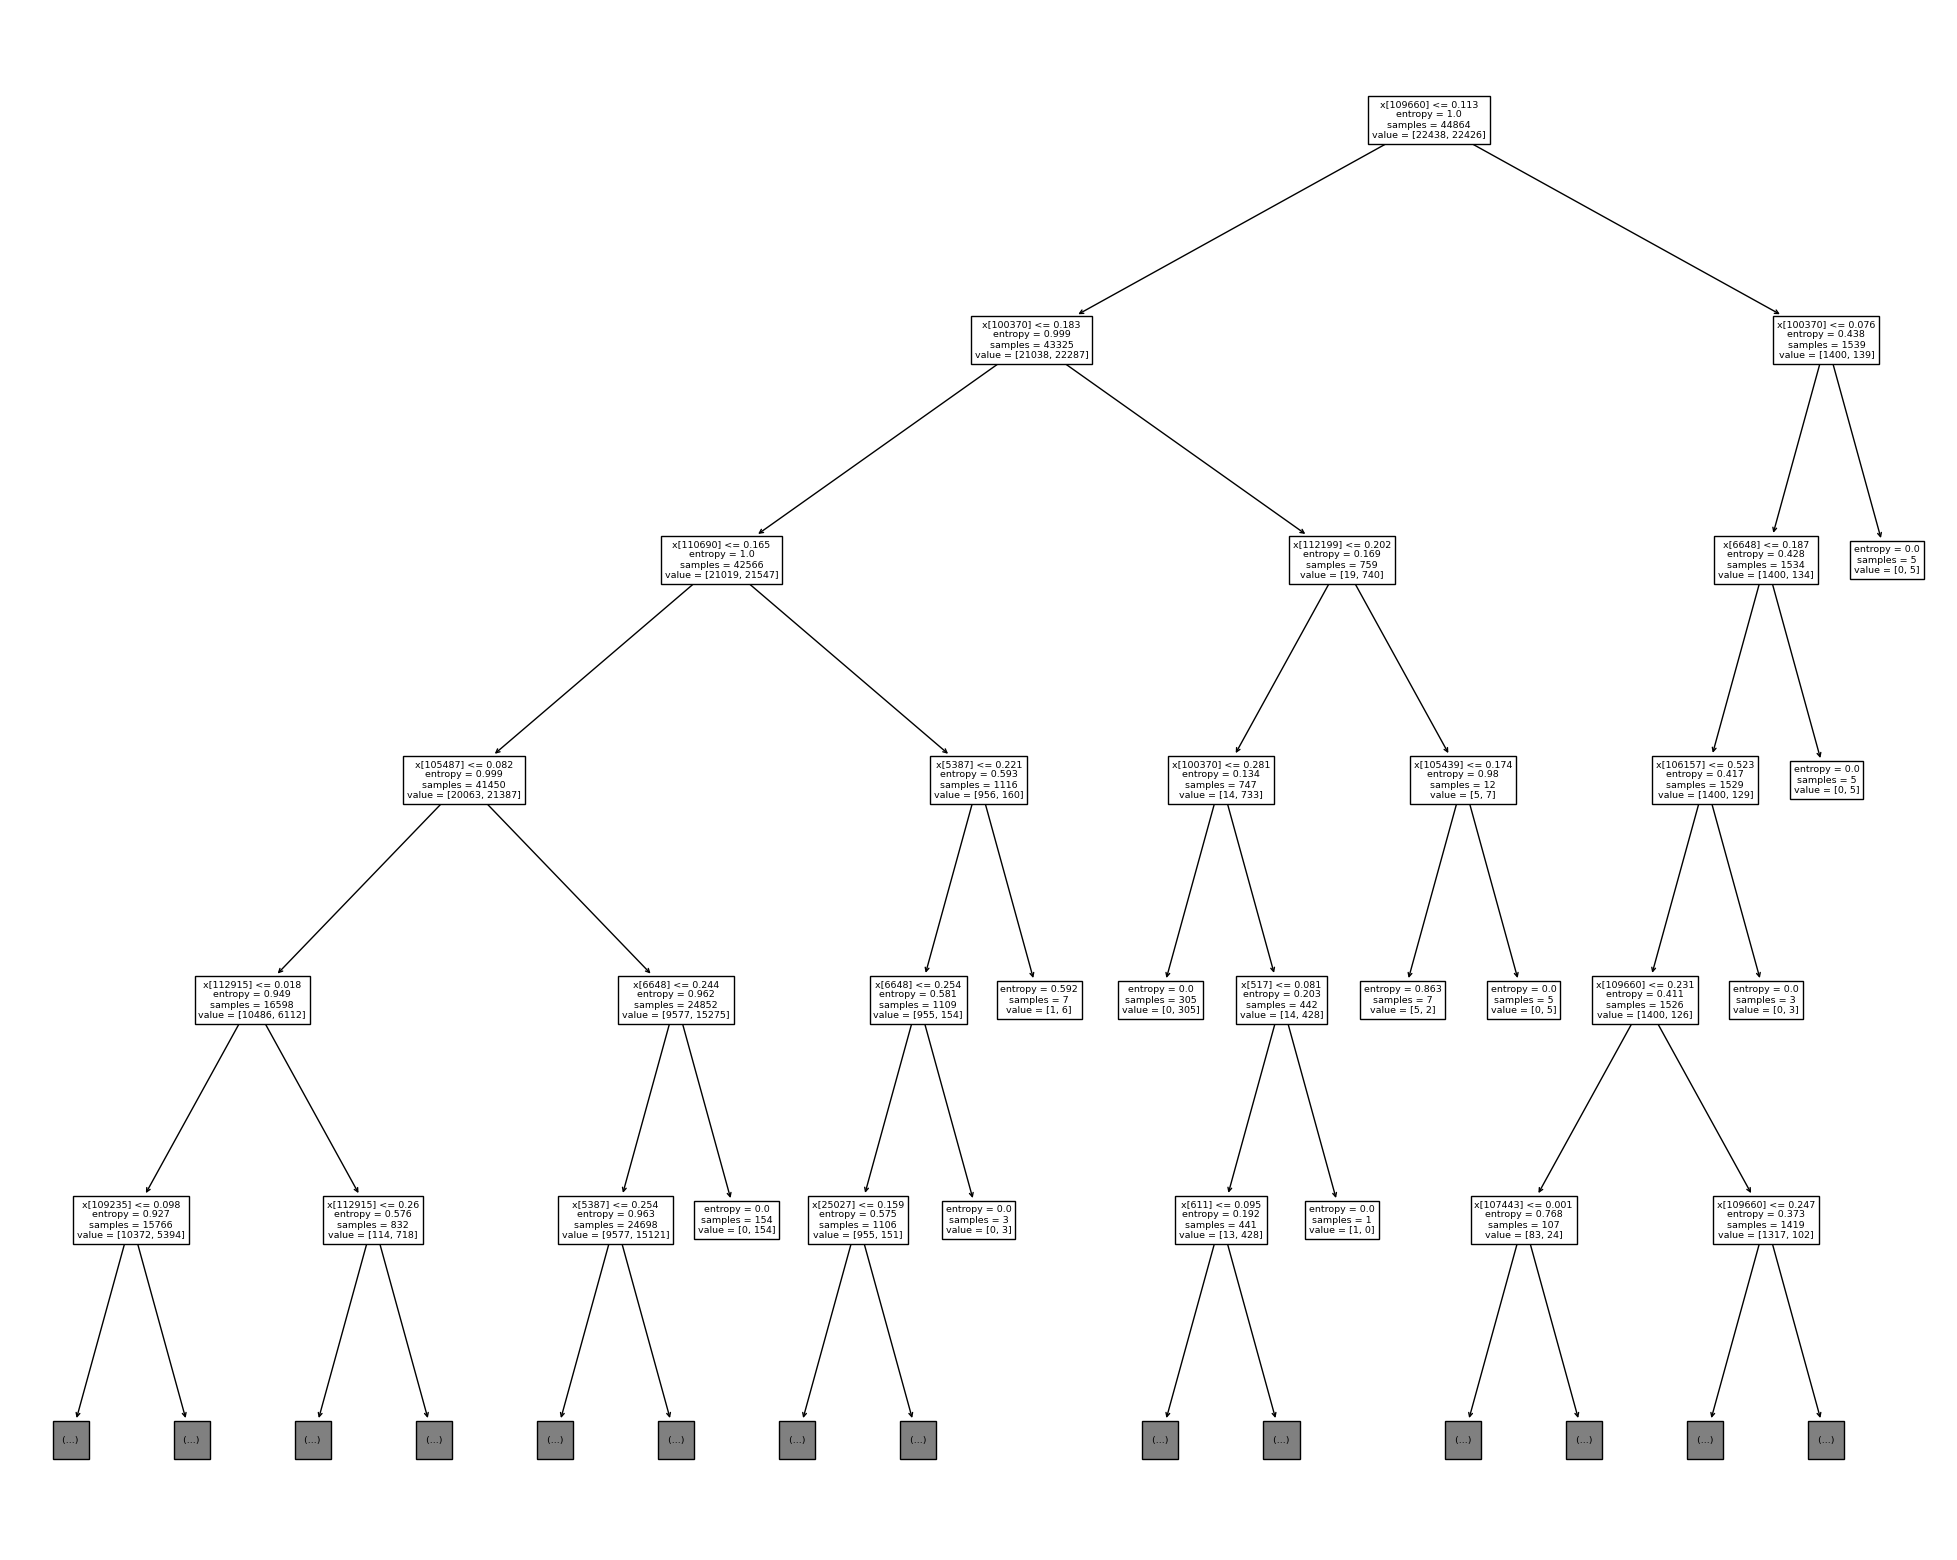

In [ ]:
from sklearn import tree
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(dtree2, 
                   max_depth = 5)


#### Classification report of the model

In [ ]:
y_pred = rand_search_dtree.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.54      0.64      5602
           1       0.65      0.86      0.74      5614

    accuracy                           0.70     11216
   macro avg       0.72      0.70      0.69     11216
weighted avg       0.72      0.70      0.69     11216



#### Confusion matrix of the model

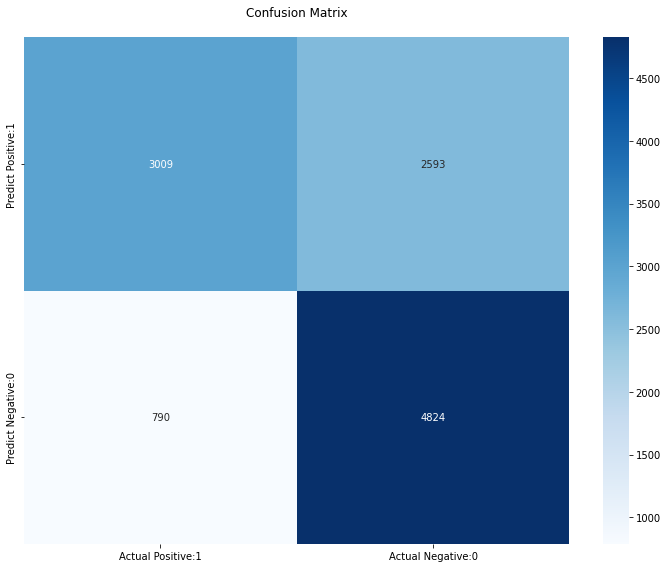

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
cm = confusion_matrix(y_test, y_pred)
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], index=['Predict Positive:1', 'Predict Negative:0'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix\n")
plt.tight_layout()

In [ ]:
file = "/content/drive/My Drive/decision.sav"
pickle.dump(logit,file)

## Random forest
The dataset is loaded into a dataframe, tokenized and vectorized, and then split into train and test sets. \\
The random forest model is then run on the training set, and tested using the testing set.

In [ ]:
file = '/content/drive/My Drive/all-without-duplicates.csv'
urls_data = pd.read_csv(file)
urls_data = urls_data.groupby('label').apply(lambda x: x.sample(n=28040))
url_list = urls_data["url"]
y = urls_data["label"]
vectorizer = TfidfVectorizer(tokenizer=tokenize)
X = vectorizer.fit_transform(url_list)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)   
randomforest = RandomForestClassifier()
randomforest.fit(X_train, y_train)
y_pred = randomforest.predict(X_test)
print("Test Accuracy ",randomforest.score(X_test, y_test))
print(" TrainAccuracy ",randomforest.score(X_train, y_train))

/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Test Accuracy  0.7047075606276747
 TrainAccuracy  0.9982837018544936


### Classification report of the model

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.56      0.65      5602
           1       0.66      0.84      0.74      5614

    accuracy                           0.70     11216
   macro avg       0.72      0.70      0.70     11216
weighted avg       0.72      0.70      0.70     11216



### Confusion matrix of the model

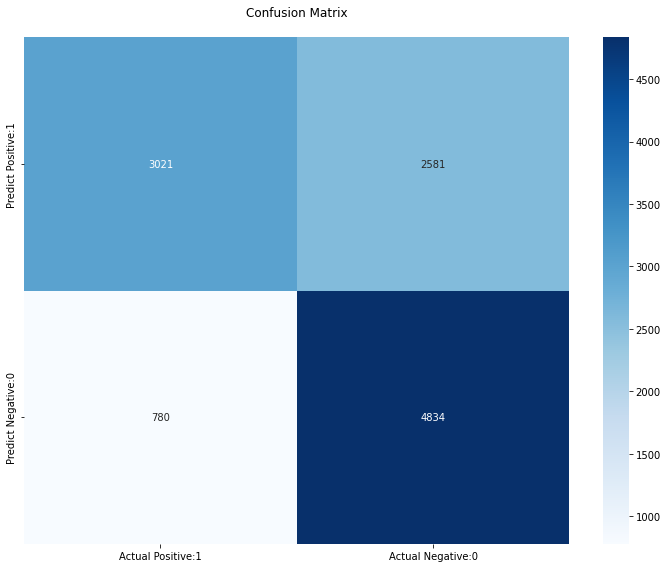

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
cm = confusion_matrix(y_test, y_pred)
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], index=['Predict Positive:1', 'Predict Negative:0'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix\n")
plt.tight_layout()

In [ ]:
filename_lgbm = '/content/drive/My Drive/random-forest.sav'
pickle.dump(randomforest,open(filename_lgbm, 'wb'))

### Randomized Search Cross Validation

In [ ]:
file = '/content/drive/My Drive/all-without-duplicates.csv'
urls_data = pd.read_csv(file)
urls_data = urls_data.groupby('label').apply(lambda x: x.sample(n=28040))
url_list = urls_data["url"]
y = urls_data["label"]
vectorizer = TfidfVectorizer(tokenizer=tokenize)
X = vectorizer.fit_transform(url_list)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)   

model = RandomForestClassifier()

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

param = {'n_estimators': n_estimators,
               'max_features': ['auto', 'sqrt'],
               'max_depth': max_depth,
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4],
               'bootstrap': [True, False]}

rand_search_random = RandomizedSearchCV(model, param_distributions=param, n_iter=10, cv=5,n_jobs=-1)

rand_search_random.fit(X_train, y_train)
print("Accuracy ",rand_search_random.score(X_test, y_test))
print("Accuracy ",rand_search_random.score(X_train, y_train))

/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Accuracy  0.696950784593438
Accuracy  0.7006062767475035


#### Classification report of the model

In [ ]:
y_pred = rand_search_random.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.54      0.64      5602
           1       0.65      0.86      0.74      5614

    accuracy                           0.70     11216
   macro avg       0.72      0.70      0.69     11216
weighted avg       0.72      0.70      0.69     11216



#### Confusion matrix of the model

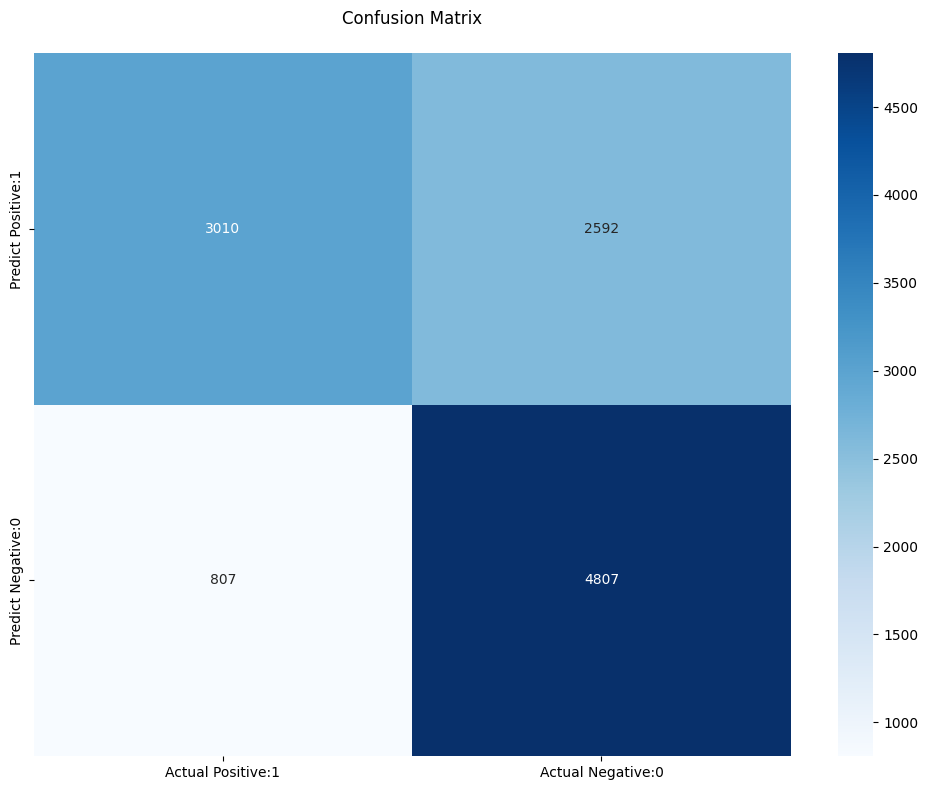

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
cm = confusion_matrix(y_test, y_pred)
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], index=['Predict Positive:1', 'Predict Negative:0'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix\n")
plt.tight_layout()

In [ ]:
filename = '/content/drive/My Drive/random-forest-randomsearch.sav'
pickle.dump(rand_search_random,open(filename, 'wb'))

## XGBoost
The dataset is loaded into a dataframe, tokenized and vectorized, and then split into train and test sets. \\
The XGBoost model is then run on the training set, and tested using the testing set.

In [ ]:
file = '/content/drive/My Drive/all-without-duplicates.csv'
urls_data = pd.read_csv(file)
urls_data = urls_data.groupby('label').apply(lambda x: x.sample(n=28040))
le = LabelEncoder()
label = le.fit_transform(urls_data['label'])
urls_data.drop('label', axis=1, inplace=True)
urls_data['label'] = label
url_list = urls_data['url']
vectorizer = TfidfVectorizer(tokenizer=tokenize)
X_tfid = vectorizer.fit_transform(url_list)
y_tfid = urls_data["label"]
X_train, X_test, y_train, y_test = train_test_split(X_tfid, y_tfid, test_size=0.2, random_state=42)   
xgb = XGBClassifier()
xgb.fit(X_train,y_train)
print("Accuracy ",xgb.score(X_test, y_test))
print("Accuracy ",xgb.score(X_train, y_train))

/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Accuracy  0.7018544935805991
Accuracy  0.7029243937232525


### Classification report of the model

In [ ]:
y_pred = xgb.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.55      0.65      5602
           1       0.65      0.85      0.74      5614

    accuracy                           0.70     11216
   macro avg       0.72      0.70      0.69     11216
weighted avg       0.72      0.70      0.69     11216



### Confusion matrix of the model

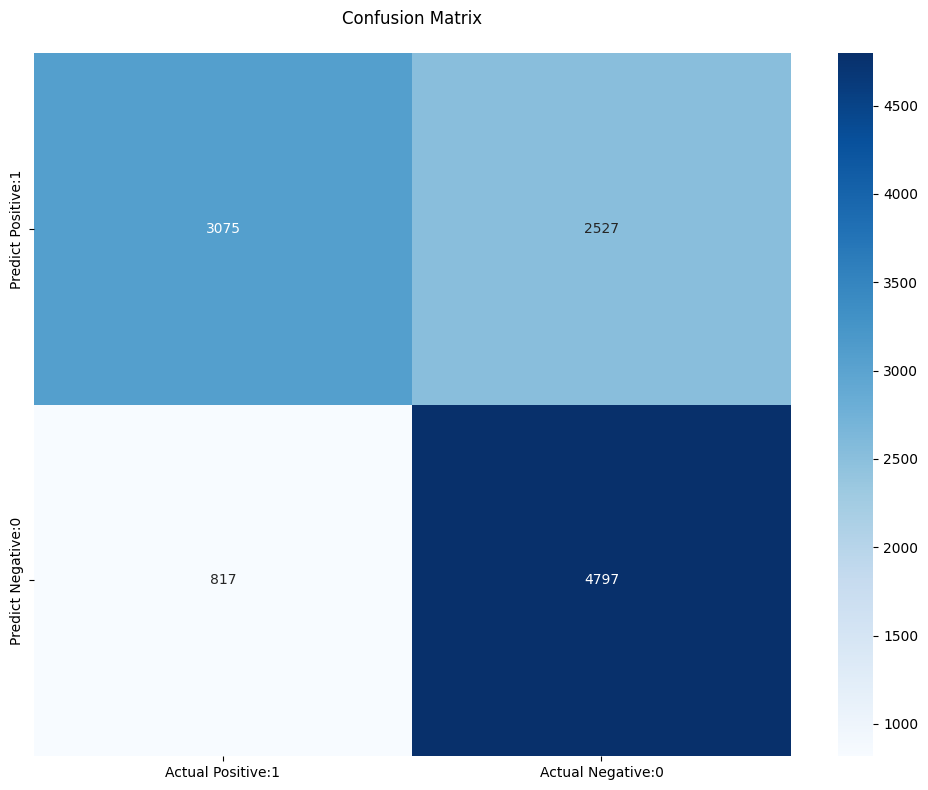

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
cm = confusion_matrix(y_test, y_pred)
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], index=['Predict Positive:1', 'Predict Negative:0'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix\n")
plt.tight_layout()

### XGBoost with GPU
Training the XGBoost model using the GPU for increased speed

In [ ]:
file = '/content/drive/My Drive/all-without-duplicates.csv'
urls_data = pd.read_csv(file)
urls_data = urls_data.groupby('label').apply(lambda x: x.sample(n=28040))
le = LabelEncoder()
label = le.fit_transform(urls_data['label'])
urls_data.drop('label', axis=1, inplace=True)
urls_data['label'] = label
url_list = urls_data['url']
vectorizer = TfidfVectorizer(tokenizer=tokenize)
X_tfid = vectorizer.fit_transform(url_list)
y_tfid = urls_data["label"]
X_train, X_test, y_train, y_test = train_test_split(X_tfid, y_tfid, test_size=0.2, random_state=42)   
xgb_gpu = XGBClassifier(tree_method = "gpu_hist")
xgb_gpu.fit(X_train,y_train)
print("Accuracy ",xgb_gpu.score(X_test, y_test))
print("Accuracy ",xgb_gpu.score(X_train, y_train))

/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Accuracy  0.6736804564907275
Accuracy  0.6807908345221113


#### Classification report of the model

In [ ]:
y_pred = xgb_gpu.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.53      0.62      5602
           1       0.64      0.81      0.71      5614

    accuracy                           0.67     11216
   macro avg       0.69      0.67      0.67     11216
weighted avg       0.69      0.67      0.67     11216



#### Confusion matrix of the model

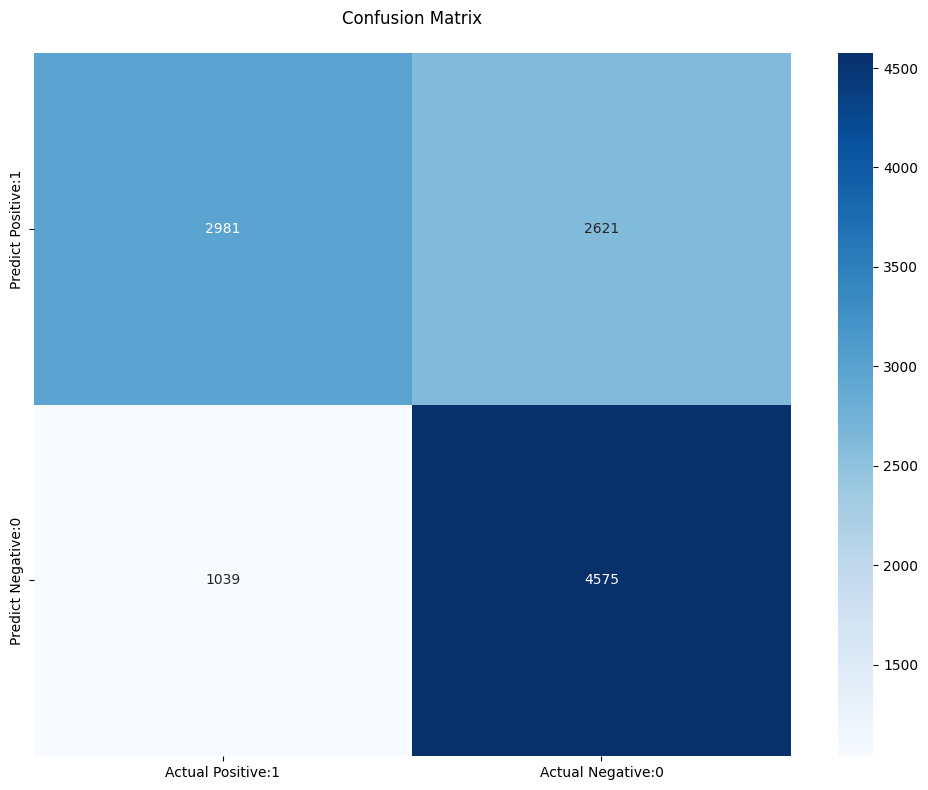

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
cm = confusion_matrix(y_test, y_pred)
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], index=['Predict Positive:1', 'Predict Negative:0'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix\n")
plt.tight_layout()

### Randomized Search Cross Validation

In [ ]:
params_xgb = { 'max_depth': [3, 5, 6, 10, 15, 20],
           'learning_rate': [0.01, 0.1, 0.2, 0.3],
           'subsample': np.arange(0.5, 1.0, 0.1),
           'colsample_bytree': np.arange(0.4, 1.0, 0.1),
           'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
           'n_estimators': [100, 500, 1000]}

file = '/content/drive/My Drive/all-without-duplicates.csv'
urls_data = pd.read_csv(file)
urls_data = urls_data.groupby('label').apply(lambda x: x.sample(n=28040))
le = LabelEncoder()

label = le.fit_transform(urls_data['label'])

urls_data.drop('label', axis=1, inplace=True)

urls_data['label'] = label
url_list = urls_data['url']
vectorizer = TfidfVectorizer(tokenizer=tokenize)
X_tfid = vectorizer.fit_transform(url_list)
y_tfid = urls_data["label"]
X_train, X_test, y_train, y_test = train_test_split(X_tfid, y_tfid, test_size=0.2, random_state=42)   
xgb = XGBClassifier()
rand_search_xgb = RandomizedSearchCV(xgb, param_distributions=params_xgb, n_iter=20, cv=5,n_jobs=-1)
rand_search_xgb.fit(X_train,y_train)
print("Accuracy ",rand_search_xgb.score(X_test, y_test))
print("Accuracy ",rand_search_xgb.score(X_train, y_train))

/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Accuracy  0.7052425106990015
Accuracy  0.7106143009985735


In [ ]:
filename_rs = '/content/drive/My Drive/xgboost-rs.sav'
pickle.dump(rand_search_xgb, open(filename_rs, 'wb'))

In [ ]:
best_params = rand_search_xgb.best_params_
xgb.set_params(**best_params)
xgb.fit(X_train, y_train)
print("Accuracy ",xgb.score(X_test, y_test))
print("Accuracy ",xgb.score(X_train, y_train))

Accuracy  0.6988231098430813
Accuracy  0.7084745007132668


#### Classification report of the model

In [ ]:
y_pred = rand_search_xgb.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.53      0.64      5602
           1       0.65      0.86      0.74      5614

    accuracy                           0.70     11216
   macro avg       0.72      0.70      0.69     11216
weighted avg       0.72      0.70      0.69     11216



#### Confusion matrix of the model

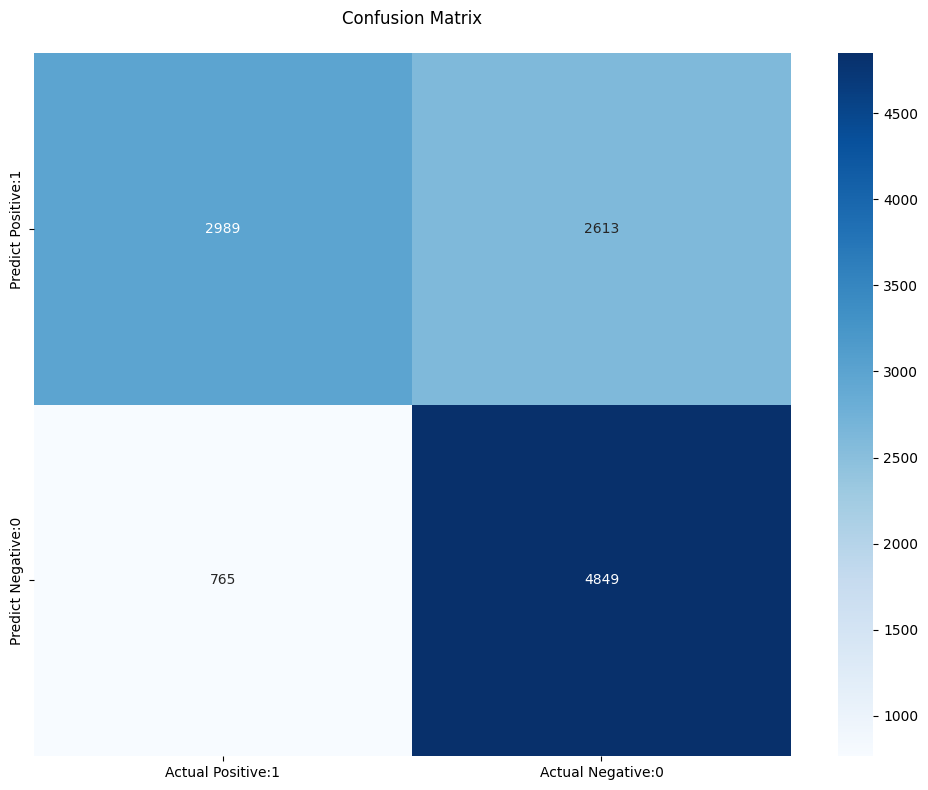

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
cm = confusion_matrix(y_test, y_pred)
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], index=['Predict Positive:1', 'Predict Negative:0'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix\n")
plt.tight_layout()

### XGBoost Bagging classifier

In [ ]:
rand_search_xgb = pickle.load(open('/content/drive/My Drive/xgboost-rs.sav', 'rb'))

file = '/content/drive/My Drive/all-without-duplicates.csv'
urls_data = pd.read_csv(file)
urls_data = urls_data.groupby('label').apply(lambda x: x.sample(n=28040))
le = LabelEncoder()

label = le.fit_transform(urls_data['label'])
 
urls_data.drop('label', axis=1, inplace=True)
 
urls_data['label'] = label
url_list = urls_data['url'] 
vectorizer = TfidfVectorizer(tokenizer=tokenize)
X_tfid = vectorizer.fit_transform(url_list)
y_tfid = urls_data["label"]
X_train, X_test, y_train, y_test = train_test_split(X_tfid, y_tfid, test_size=0.2, random_state=42)   

bagging_xgb = BaggingClassifier(estimator=rand_search_xgb, n_estimators=10, random_state=42)
bagging_c.fit(X_train, y_train)

print("Accuracy ",bagging_xgb.score(X_test, y_test))
print("Accuracy ",bagging_xgb.score(X_train, y_train))

Accuracy  0.6981990014265336
Accuracy  0.7113721469329529


#### Classification report of the model

In [ ]:
y_pred = bagging_xgb.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.54      0.64      5602
           1       0.65      0.86      0.74      5614

    accuracy                           0.70     11216
   macro avg       0.72      0.70      0.69     11216
weighted avg       0.72      0.70      0.69     11216



#### Confusion matrix of the model

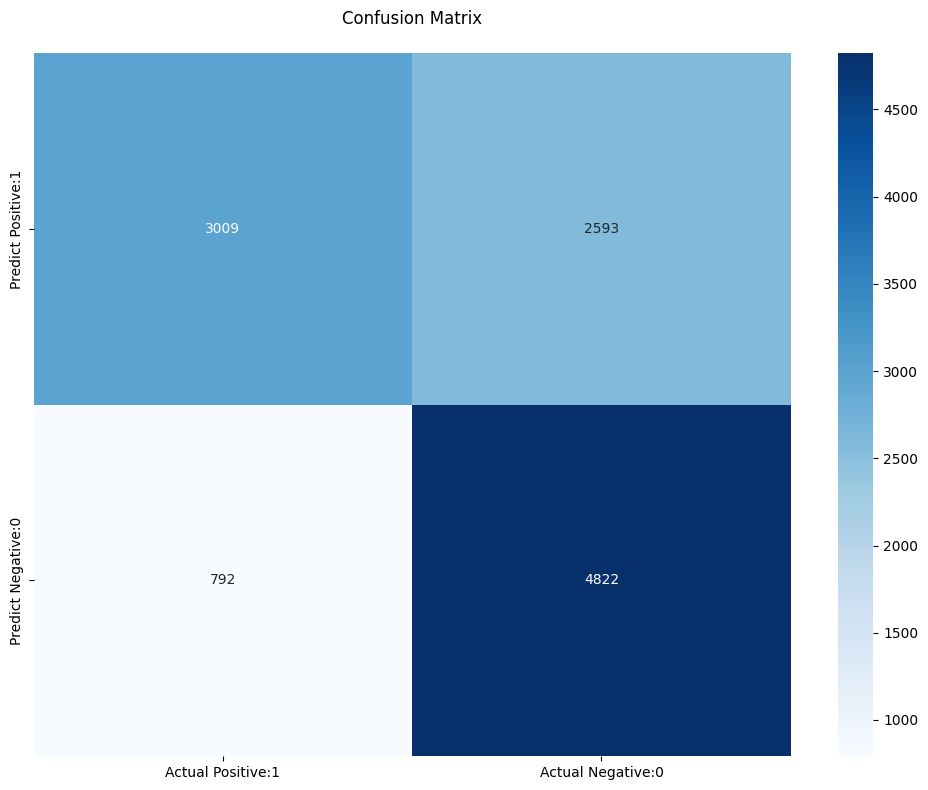

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
cm = confusion_matrix(y_test, y_pred)
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], index=['Predict Positive:1', 'Predict Negative:0'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix\n")
plt.tight_layout()

### Stacking

In [ ]:
filename = '/content/drive/My Drive/xgboost.sav'
rand_search_xgb = pickle.load(open(filename, 'rb'))

In [ ]:
estimators = [
    ("xgb", XGBClassifier(n_estimators=250,max_depth=9,learning_rate=1))
]
file = '/content/drive/My Drive/all-without-duplicates.csv'
urls_data = pd.read_csv(file)
urls_data = urls_data.groupby('label').apply(lambda x: x.sample(n=28040))

le = LabelEncoder()
label = le.fit_transform(urls_data['label'])
urls_data.drop('label', axis=1, inplace=True)
urls_data['label'] = label
url_list = urls_data['url']
vectorizer = TfidfVectorizer(tokenizer=tokenize)
X = vectorizer.fit_transform(url_list)
y = urls_data["label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)   


stacking_xgb = StackingClassifier(estimators=estimators)
stacking_xgb.fit(X_train, y_train)
print("Accuracy ",stacking_xgb.score(X_test, y_test))

/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Accuracy  0.6987339514978602


#### Classification report of the model

In [ ]:
y_pred = stacking_xgb.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.79      0.54      0.64      5602
           1       0.65      0.85      0.74      5614

    accuracy                           0.70     11216
   macro avg       0.72      0.70      0.69     11216
weighted avg       0.72      0.70      0.69     11216



#### Confusion matrix of the model

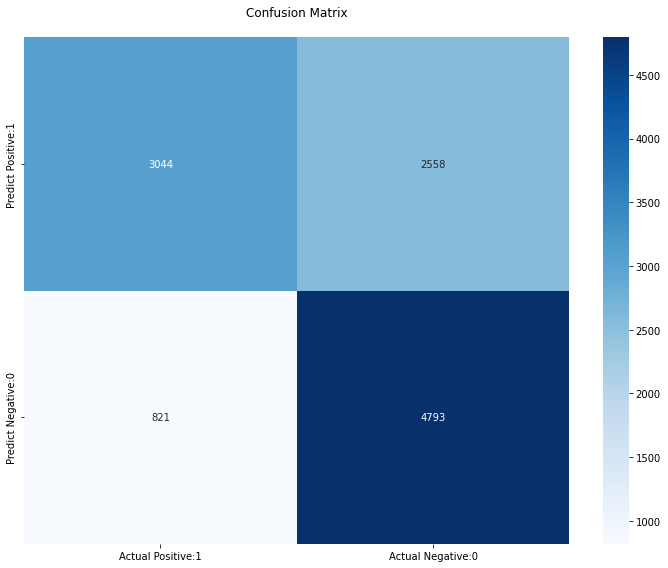

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
cm = confusion_matrix(y_test, y_pred)
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], index=['Predict Positive:1', 'Predict Negative:0'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix\n")
plt.tight_layout()

## LightGBM
The dataset is loaded into a dataframe, tokenized and vectorized, and then split into train and test sets. \\
The LightGBM model is then run on the training set, and tested using the testing set.

In [ ]:
file = '/content/drive/My Drive/all-without-duplicates.csv'
urls_data = pd.read_csv(file)
urls_data = urls_data.groupby('label').apply(lambda x: x.sample(n=28040))
url_list = urls_data["url"]
y = urls_data["label"]
vectorizer = TfidfVectorizer(tokenizer=tokenize)
X = vectorizer.fit_transform(url_list)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)   

lgbm = lgb.LGBMClassifier(objective='binary', boosting = ["dart"], bagging_fraction = 0.5, bagging_freq = 20, skip_drop = 0.6, max_drop = 20, drop_rate = 0.01)
lgbm.fit(X_train, y_train)
y_pred=lgbm.predict(X_test)
accuracy=accuracy_score(y_pred, y_test)
print('LightGBM accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_pred)))
y_pred_train = lgbm.predict(X_train)
print('LightGBM Model training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train)))
accuracy=accuracy_score(y_pred, y_test)
print('LightGBM Model testing-set accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_pred)))

/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] bagging_freq is set=20, subsample_freq=0 will be ignored. Current value: bagging_freq=20
LightGBM accuracy score: 0.7020
LightGBM Model training-set accuracy score: 0.6966
LightGBM Model testing-set accuracy score: 0.7020


### Classification report for the model

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.55      0.65      5602
           1       0.65      0.86      0.74      5614

    accuracy                           0.70     11216
   macro avg       0.72      0.70      0.69     11216
weighted avg       0.72      0.70      0.69     11216



### Confusion matrix of the model

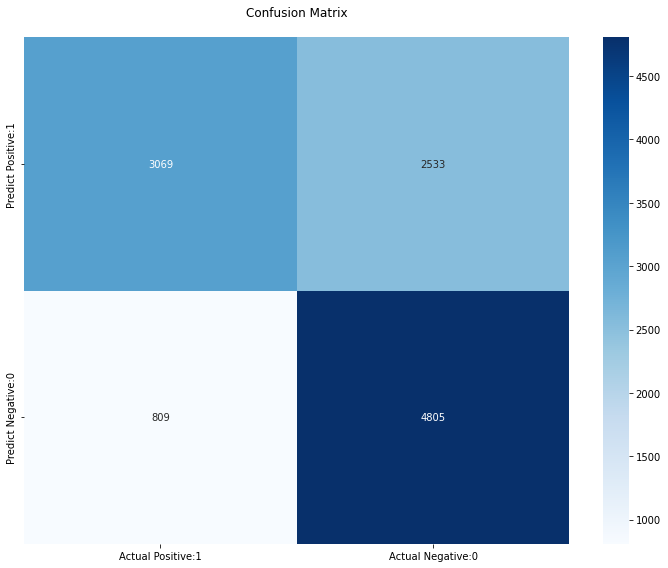

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
cm = confusion_matrix(y_test, y_pred)
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], index=['Predict Positive:1', 'Predict Negative:0'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix\n")
plt.tight_layout()

In [ ]:
filename_lgbm = '/content/drive/My Drive/light-gbm-better.sav'
pickle.dump(lgbm,open(filename_lgbm, 'wb'))

### Randomized Search Cross Validation

In [ ]:
params_lgbm = {
          'num_leaves': np.arange(100,500,100),
          'min_child_weight': np.arange(0.01,1,0.01),
          'feature_fraction': np.arange(0.1,0.4,0.01),
          'bagging_fraction':np.arange(0.3,0.5,0.01),
          'min_data_in_leaf': np.arange(100,1500,10),
          'objective': ['binary'],
          'max_depth': [-1],
          'learning_rate':np.arange(0.001,0.02,0.001),
          "boosting_type": ['dart'],
          "bagging_seed": np.arange(10,42,5),
          "metric": ['auc'],
          "verbosity": [1],
          'reg_alpha': np.arange(0.3,1,0.2),
          'reg_lambda':  np.arange(0.37,0.39,0.001),
          'random_state': [425],
          'n_estimators': [500]}

file = '/content/drive/My Drive/all-without-duplicates.csv'
urls_data = pd.read_csv(file)
urls_data = urls_data.groupby('label').apply(lambda x: x.sample(n=28040))

le = LabelEncoder()

label = le.fit_transform(urls_data['label'])

urls_data.drop('label', axis=1, inplace=True)

urls_data['label'] = label
url_list = urls_data['url']
vectorizer = TfidfVectorizer(tokenizer=tokenize)
X_tfid = vectorizer.fit_transform(url_list)
y_tfid = urls_data["label"]
X_train, X_test, y_train, y_test = train_test_split(X_tfid, y_tfid, test_size=0.2)   
lgbm = lgb.LGBMClassifier()
rand_search_lgbm = RandomizedSearchCV(lgbm, param_distributions=params_lgbm, n_iter=20, cv=5,n_jobs=-1)
rand_search_lgbm.fit(X_train,y_train)
print("Accuracy ",rand_search_lgbm.score(X_test, y_test))
print("Accuracy ",rand_search_lgbm.score(X_train, y_train))

/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.30999999999999994, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30999999999999994
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] bagging_fraction is set=0.4500000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4500000000000001
[LightGBM] [Warning] feature_fraction is set=0.30999999999999994, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30999999999999994
[LightGBM] [Warning] min_data_in_leaf is set=110, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=110
[LightGBM] [Warning] bagging_fraction is set=0.4500000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4500000000000001
[LightGBM] [Info] Number of positive: 22393, number of negative: 22471
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead o

#### Classification report of the model

In [ ]:
y_pred=rand_search_lgbm.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.55      0.64      5569
           1       0.65      0.83      0.73      5647

    accuracy                           0.69     11216
   macro avg       0.71      0.69      0.68     11216
weighted avg       0.71      0.69      0.68     11216



#### Confusion matrix of the model

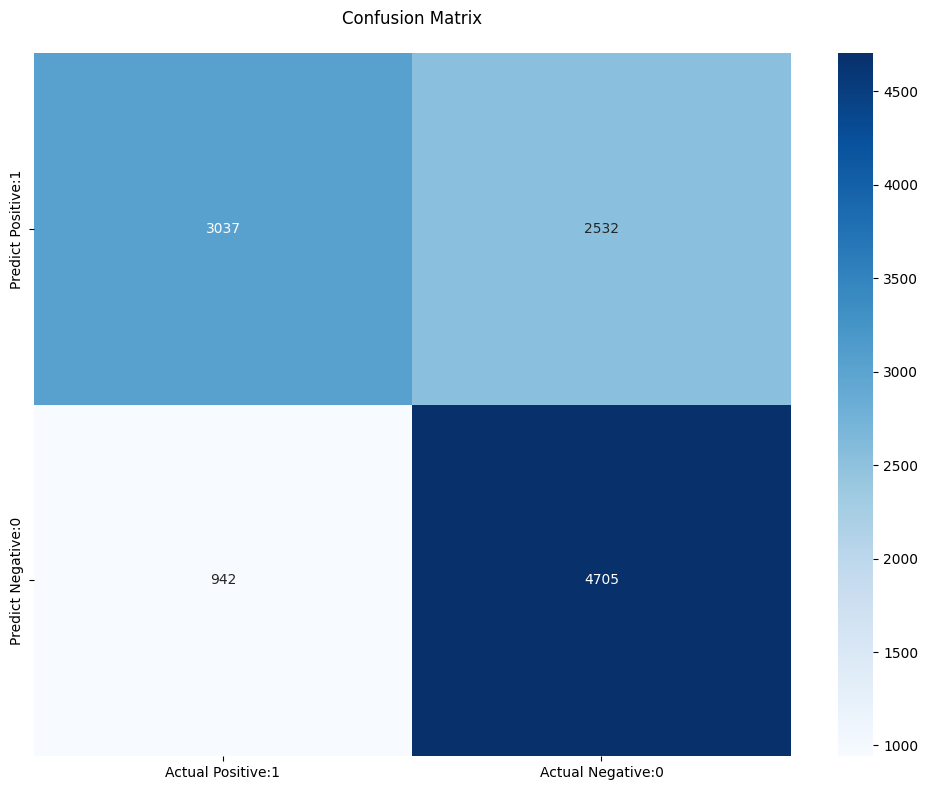

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
cm = confusion_matrix(y_test, y_pred)
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], index=['Predict Positive:1', 'Predict Negative:0'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix\n")
plt.tight_layout()

## Support Vector Machine (SVM)
The dataset is loaded into a dataframe, tokenized and vectorized, and then split into train and test sets. \\
The SVM model is then run on the training set, and tested using the testing set.

In [ ]:
file = '/content/drive/My Drive/all-without-duplicates.csv'
urls_data = pd.read_csv(file)
urls_data = urls_data.groupby('label').apply(lambda x: x.sample(n=28040))
url_list = urls_data["url"]
y = urls_data["label"]
vectorizer = TfidfVectorizer(tokenizer=tokenize)
X = vectorizer.fit_transform(url_list)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)   

svm = LinearSVC()
svm.fit(X_train, y_train)
print("score on test: " + str(svm.score(X_test, y_test)))
print("score on train: "+ str(svm.score(X_train, y_train)))


/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


score on test: 0.7026569186875892
score on train: 0.998239122681883


### Classification report of the model

In [ ]:
y_pred = svm.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.54      0.64      5602
           1       0.65      0.87      0.75      5614

    accuracy                           0.70     11216
   macro avg       0.73      0.70      0.69     11216
weighted avg       0.73      0.70      0.69     11216



### Confusion matrix of the model

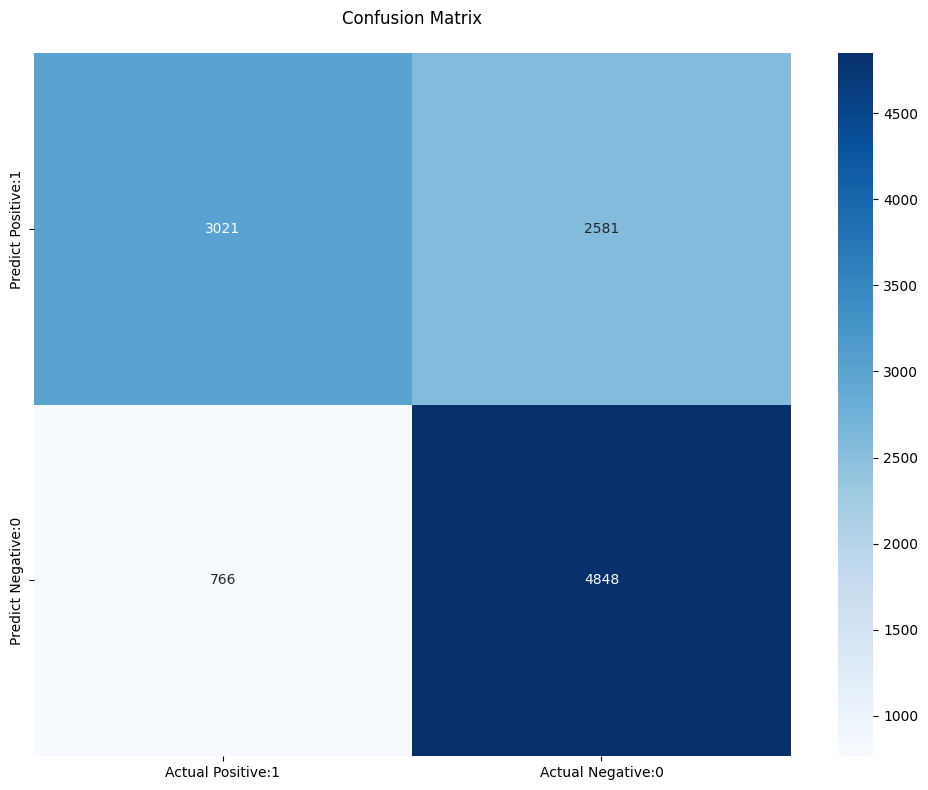

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
cm = confusion_matrix(y_test, y_pred)
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], index=['Predict Positive:1', 'Predict Negative:0'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix\n")
plt.tight_layout()

### Grid Search Cross Validation


In [ ]:
param_dist = {'C': np.logspace(-3, 3, 7),
              'max_iter': [10000],
              'tol': [1e-3, 1e-4, 1e-5]}

file = '/content/drive/My Drive/all-without-duplicates.csv'
urls_data = pd.read_csv(file)
urls_data = urls_data.groupby('label').apply(lambda x: x.sample(n=28040))
X = urls_data["url"]
y = urls_data["label"]
vectorizer = TfidfVectorizer(tokenizer=tokenize)
X = vectorizer.fit_transform(X)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)   

svm=LinearSVC()
grid_search_svm = GridSearchCV(svm, param_grid=param_dist, cv=10,n_jobs=-1)

grid_search_svm.fit(x_train, y_train)
print("score on test: " + str(grid_search_svm.score(x_test, y_test)))
print("score on train: "+ str(grid_search_svm.score(x_train, y_train)))

/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


score on test: 0.7008737517831669
score on train: 0.9986626248216833


In [ ]:
filename_svm = '/content/drive/My Drive/grid-search-try-0106.sav'
pickle.dump(grid_search_svm,open(filename_svm, 'wb'))

#### Classification report of the model

In [ ]:
y_pred = grid_search_svm.predict(x_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.81      0.54      0.65      5602
           1       0.65      0.87      0.75      5614

    accuracy                           0.71     11216
   macro avg       0.73      0.71      0.70     11216
weighted avg       0.73      0.71      0.70     11216



#### Confusion matrix of the model

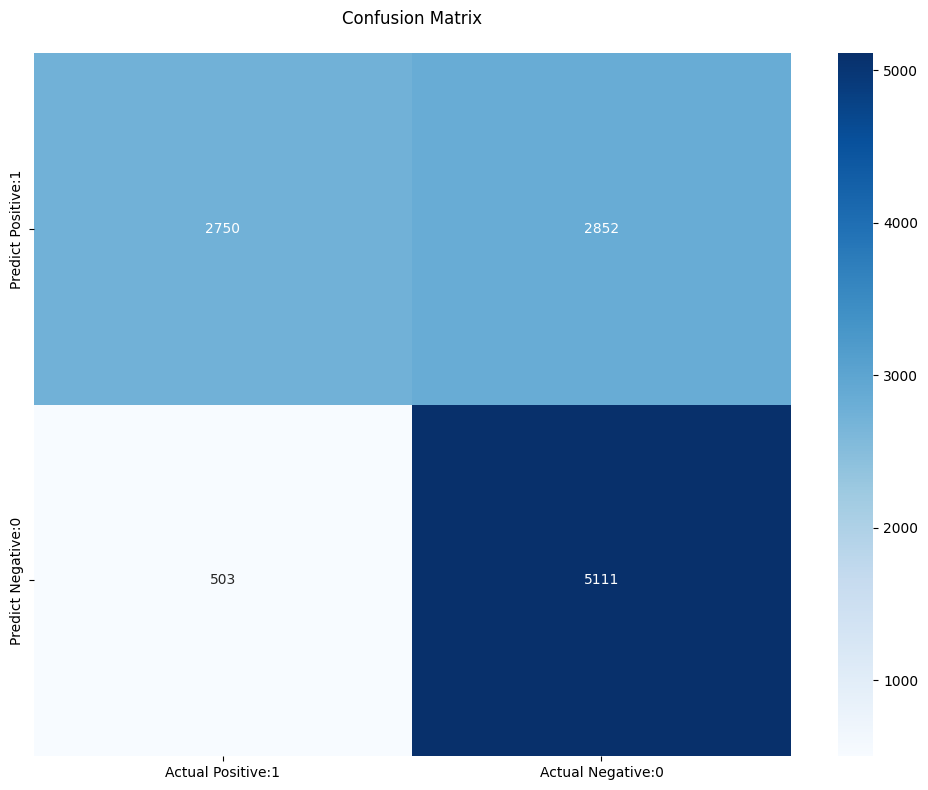

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
cm = confusion_matrix(y_test, y_pred)
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], index=['Predict Positive:1', 'Predict Negative:0'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix\n")
plt.tight_layout()